# №8 Различия в прибыли по поставщикам.

**Формулировка гипотезы**  

H₀: Средняя прибыль от продаж разных поставщиков одинакова.  
H₁: Средняя прибыль различается в зависимости от поставщика.  

**Тесты**
- Kruskal-Wallis H-test
    - Размер эффекта eta-squared
    - Пост-хок Dunn test (Bonferroni)

### Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sqlalchemy
import configparser
from scipy import stats
from scipy.stats import skew, kurtosis
from scipy.stats import kruskal
import scikit_posthocs as sp 
from itertools import combinations
 # Импортируем класс из файла db_connection.py
from db_connection import PostgresConnection
# Импортируем класс из файла data_cleaner.py
from data_cleaner import DataCleaner

In [2]:
# Создаем объект для работы с базой данных
db_connection = PostgresConnection()

query = 'SELECT * FROM sales'
data = db_connection.execute_query(query)

### Подготовка данных

In [3]:
# Создаем объект DataCleaner с данным DataFrame
cleaner = DataCleaner(data)

# Удаляем строки с отрицательными значениями в 'dr_sdisc' и 'dr_kol'
cleaned_data = cleaner.drop_negative_values()

# Удаляем строки, где 'dr_nchk' имеет значения из списка [21, 593, 2495]
cleaned_data = cleaner.drop_error_check_values()

### Формирование чеков

In [4]:
cleaned_data['profit_without_discount'] = (cleaned_data['dr_croz'] - cleaned_data['dr_czak']) * cleaned_data['dr_kol']
grouped = cleaned_data.groupby(['dr_tabempl', 'dr_apt', 'dr_nchk', 'dr_dat']).agg({'profit_without_discount':'sum',\
                                                            'dr_sdisc':'max', 'dr_suppl':'max'}).reset_index()
grouped['profit'] = grouped['profit_without_discount'] - grouped['dr_sdisc']
grouped.head()

,dr_tabempl,dr_apt,dr_nchk,dr_dat,profit_without_discount,dr_sdisc,dr_suppl,profit
0,15,11,2491,2022-05-03,349.08,0.0,Протек,349.08
1,15,11,2497,2022-05-04,93.31,0.0,Катрен г.Химки,93.31
2,15,11,2499,2022-05-04,110.30,0.0,Катрен г.Химки,110.30
3,15,11,2501,2022-05-04,48.90,0.0,Протек,48.90
4,15,11,2503,2022-05-04,36.23,0.0,Катрен г.Химки,36.23


### EDA

**Статистика по группам**

In [5]:
# 1. Статистика 
grouped.groupby('dr_suppl')['profit'].agg(
    mean='mean',
    median='median',
    count='count'
).reset_index().round(2)

,dr_suppl,mean,median,count
0,АЛВИЛС ООО,700.00,700.00,1
1,Авеста,62.79,46.42,414
2,Арал плюс,78.85,50.48,308
3,БСС,59.65,31.28,126
4,ВИТТА КОМПАНИ ООО,82.48,48.52,350
5,Вернигор Николай Викторович,86.00,86.00,1
6,ГК Надежда Фарм,55.95,30.06,224
7,ГРАНД КАПИТАЛ СМОЛЕНСК ООО ФК,70.99,43.10,1217
8,ЕАПТЕКА ООО,70.99,50.94,366
9,Здравсервис,72.83,45.48,705


**Формирование выборок**

Для обеспечения корректности статистического анализа поставщики с числом наблюдений менее 30 были объединены в одну категорию под названием "Другие", поскольку статистические методы требуют достаточного объёма данных в каждой группе.

In [6]:
# Посчитаем количество продаж по каждому поставщику
supplier_counts = grouped['dr_suppl'].value_counts()

# Задаем порог минимального числа продаж для включения в анализ
min_count = 30

# Определяем поставщиков с маленьким числом продаж
rare_suppliers = supplier_counts[supplier_counts < min_count].index

# Объединяем редкие группы в "Другие"
grouped['supplier_grouped'] = grouped['dr_suppl'].replace(rare_suppliers, 'Другие')

# Проверим результат
print(grouped['supplier_grouped'].value_counts())

supplier_grouped
Пульс                                                 7704
Катрен г.Химки                                        3649
Протек                                                2872
ГРАНД КАПИТАЛ СМОЛЕНСК ООО ФК                         1217
Фармкомплект ООО                                      1195
Здравсервис                                            705
СТЭЛМАС-Д ООО                                          434
Авеста                                                 414
ПрофитМед                                              395
ЕАПТЕКА ООО                                            366
ВИТТА КОМПАНИ ООО                                      350
ООО "Акцентмед"                                        341
Магнит Фарма ООО                                       339
Арал плюс                                              308
ГК Надежда Фарм                                        224
Норман                                                 186
БСС                                    

**Визуализация распределений**

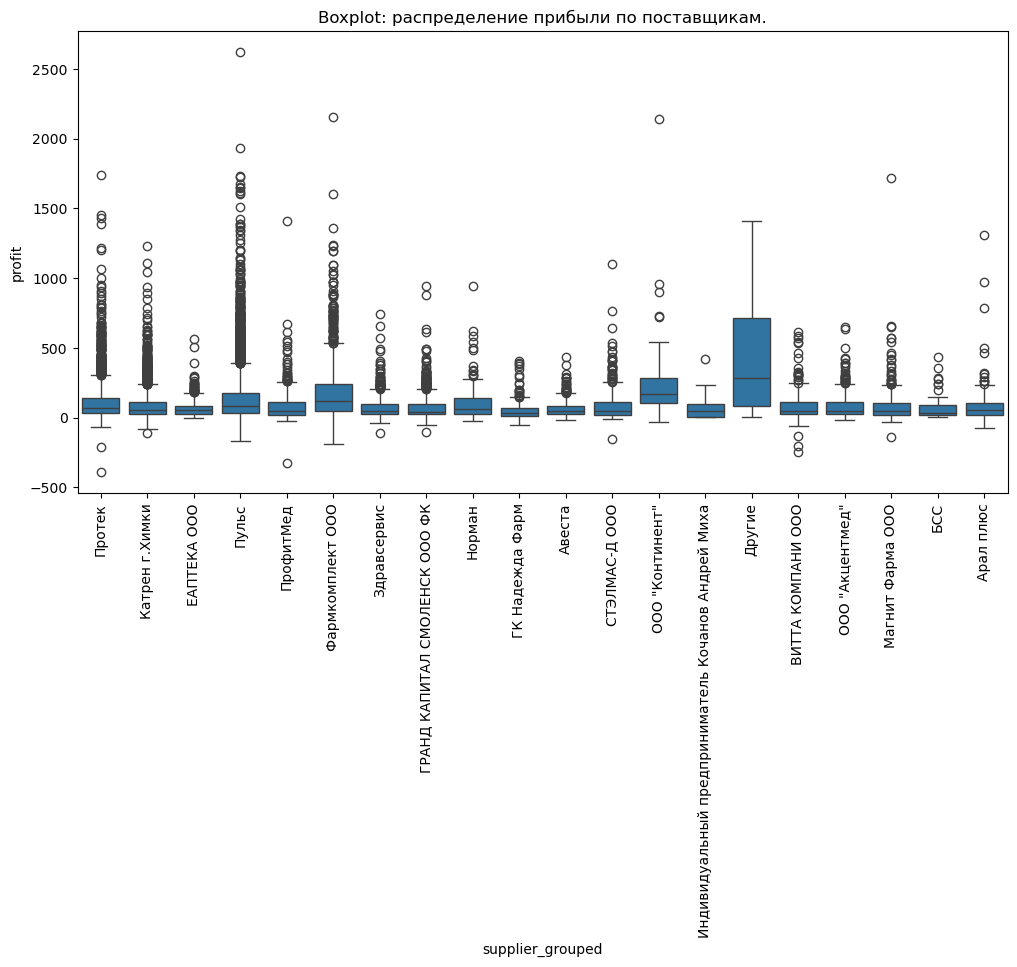

In [7]:
# 1. -- Boxplot — сравнение распределений по медианам и разбросу
plt.figure(figsize=(12, 6))
sns.boxplot(x="supplier_grouped", y="profit", data=grouped)
plt.title("Boxplot: распределение прибыли по поставщикам.")
plt.xticks(rotation=90)
plt.show()

Распределение прибыли по поставщикам отличается высокой вариативностью: у большинства наблюдаются асимметричные распределения с большим числом выбросов. Наиболее стабильные и высокие значения медианы прибыли — у поставщиков «Протек», «Катрен г. Химки», «ЕАПТЕКА ООО» и «Пульс», что указывает на их значимый вклад в прибыль. В то же время поставщик «ООО Континент» демонстрирует более низкую медиану прибыли и высокую разбросанность значений, что может свидетельствовать о неэффективной товарной матрице или закупочных условиях.

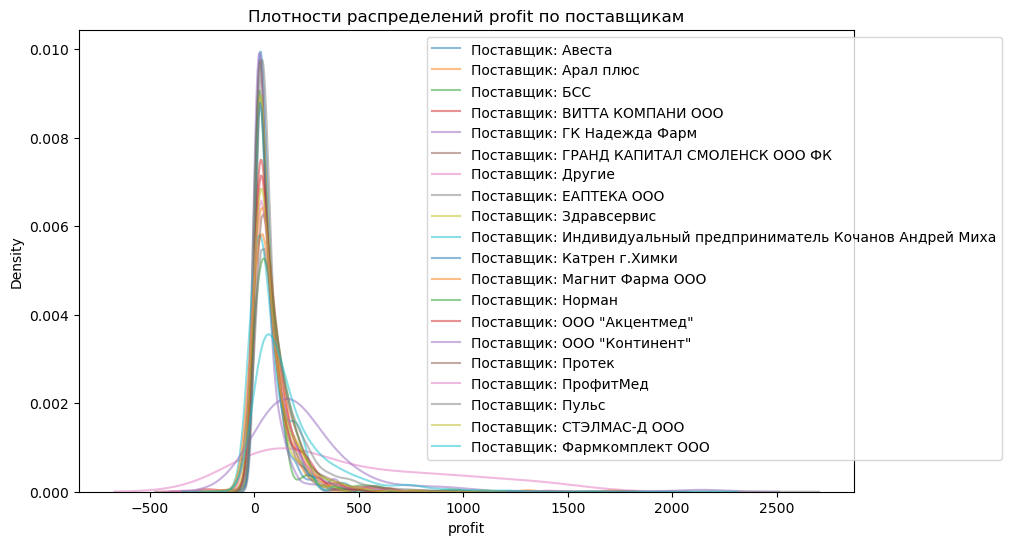

In [8]:
groups = grouped.groupby('supplier_grouped')['profit']

# 2. -- Визуализация плотностей KDE
plt.figure(figsize=(10, 6))
for name, group in groups:
    sns.kdeplot(group, label=f"Поставщик: {name}", alpha=0.5)
plt.title("Плотности распределений profit по поставщикам")
plt.xlabel("profit")
#plt.legend()
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

Форма распределений

1. Центральная симметрия и пиковость:
- Большинство распределений имеют один выраженный пик, находятся вблизи нуля и имеют симметричную форму с длинными хвостами.
- Однако видно, что распределения асимметричны у некоторых поставщиков (например, присутствуют длинные правые хвосты у отдельных линий), а некоторые – шире или уже, чем другие.

2. Сравнимость распределений между собой:
- Распределения не идентичны, но в целом схожи по форме — большинство пиков расположены вблизи нуля, и визуально плотности похожи.
- Это допустимо для применения Kruskal–Wallis H-теста, поскольку он не требует нормальности и работает на рангах, но желательно, чтобы формы распределений были сравнимыми — что здесь в целом выполняется.

Нормальность отвергается визуально:
- Есть асимметрия (у некоторых сильная), выраженные хвосты, пики – все это указывает на отклонение от нормального распределения.
- Для нормального распределения ожидается колоколообразная симметричная форма, чего здесь не наблюдается у многих поставщиков.

### Kruskal–Wallis H-тест

### Проверка предпосылок

Kruskal–Wallis H-тест подходит для сравнения медианных значений прибыли между поставщиками:
- данные не являются нормально распределёнными, а тест нечувствителен к отклонениям от нормальности,
- группы имеют сравнимые формы распределений

### Проведение теста

In [9]:
# ---------------------------
# Kruskal-Wallis H-test
# ---------------------------
# Собираем массивы значений по группам
groups = [g['profit'].values for _, g in grouped.groupby('supplier_grouped')]

if len(groups) < 2:
    raise ValueError("Недостаточно групп для сравнения (нужно >=2).")

stat, p = kruskal(*groups)
print("=== Kruskal-Wallis H-test ===")
print(f"stat = {stat:.4f}, p-value = {p:.6e}")

# ---------------------------
# Оценка размера эффекта (eta-squared для KW)
# ---------------------------
n = len(grouped)
k = grouped['supplier_grouped'].nunique()
eta2 = (stat - k + 1) / (n - k) if (n - k) > 0 else np.nan
eta2 = max(0.0, eta2)  # не давать отрицательное значение
print("\n=== Effect size: Eta squared (η²) ===")
print(f"Eta-squared (оценка размера эффекта) = {eta2:.4f}")

# ---------------------------
# Пост-хок: Dunn test (с коррекцией Bonferroni)
# ---------------------------
if p < 0.05:
    # posthoc_dunn принимает DataFrame и имена колонок
    dunn = sp.posthoc_dunn(grouped, val_col='profit', group_col='supplier_grouped', p_adjust='bonferroni')
else:
    print("\nKruskal-Wallis не показывает значимых различий — пост-хок не выполняем.")

=== Kruskal-Wallis H-test ===
stat = 1297.2354, p-value = 1.380135e-263

=== Effect size: Eta squared (η²) ===
Eta-squared (оценка размера эффекта) = 0.0610


Результаты пост-хок анализа позволяют выявить пары поставщиков с достоверными различиями в показателях, что может служить основой для последующего анализа их эффективности. Выделенные значимые различия могут быть использованы при принятии управленческих решений, направленных на оптимизацию взаимодействия с поставщиками. На основании анализа значимых пар на основе пост-хок теста Данна можно предпринять следующие действия: 
- Пересмотреть договорённости с поставщиками с низкой прибылью: условия закупок, бонусные схемы, возврат неликвидов.  
- Усилить ассортимент от поставщиков с высокой маржинальностью.  
- Рассмотреть маркетинговые акции: если товары поставщика низкомаржинальны, но популярны, их можно использовать как «локомотивы», компенсируя другими позициями.  
- Исключить/сократить ассортимент у поставщиков с крайне низкой маржой и небольшим оборотом.  
- Формировать отчёты по динамике: проверять, сохраняются ли различия со временем (например, квартал к кварталу).

#### Анализ значимых пар на основе пост-хок теста Данна

Для выявления конкретных пар поставщиков, между которыми наблюдаются статистически значимые различия, был проведён пост-хок тест Данна. Ниже представлена процедура фильтрации результатов, при которой отбираются только те пары, для которых p-значение оказалось ниже порогового уровня значимости (p < 0.05).

In [10]:
# агрегаты по поставщикам
supplier_stats = (
    grouped.groupby('dr_suppl')['profit']
      .agg(mean_profit='mean', median_profit='median', count='count')
      .reset_index()
)

# Соберём все уникальные пары (a,b) и возьмём p-value из матрицы dunn
pairs = []
names = list(dunn.index)  # в dunn и индексы, и колонки — имена групп
for a, b in combinations(names, 2):
    try:
        p = dunn.loc[a, b]
    except KeyError:
        p = dunn.loc[b, a]  # на случай другой ориентации
    # Пропускаем, если NaN
    if pd.isna(p):
        continue
    pairs.append({'supplier_1': a, 'supplier_2': b, 'p_value': p})

pairs_df = pd.DataFrame(pairs)

# Оставляем только значимые пары (p < 0.05)
significant_pairs = pairs_df[pairs_df['p_value'] < 0.05].copy()

# Добавляем статистики по первой и второй группе
supplier_stats_1 = supplier_stats.rename(columns={
    'dr_suppl': 'supplier_1',
    'mean_profit': 'mean_1',
    'median_profit': 'median_1',
    'count': 'count_1'
})
supplier_stats_2 = supplier_stats.rename(columns={
    'dr_suppl': 'supplier_2',
    'mean_profit': 'mean_2',
    'median_profit': 'median_2',
    'count': 'count_2'
})

significant_pairs = significant_pairs.merge(supplier_stats_1, on='supplier_1', how='left')
significant_pairs = significant_pairs.merge(supplier_stats_2, on='supplier_2', how='left')

# Добавляем разницу средних и абсолютную разницу (для сортировок)
significant_pairs['delta_mean'] = significant_pairs['mean_1'] - significant_pairs['mean_2']
significant_pairs['abs_delta_mean'] = significant_pairs['delta_mean'].abs()

# Два удобных представления:
#    a) по значимости (самые маленькие p)
by_p = significant_pairs.sort_values('p_value').reset_index(drop=True)

#    b) по величине разницы в среднем (кто реально "выигрывает" больше в рублях)
by_delta_desc = significant_pairs.sort_values('delta_mean', ascending=False).reset_index(drop=True)  # supplier_1 >> supplier_2
by_delta_asc  = significant_pairs.sort_values('delta_mean', ascending=True).reset_index(drop=True)   # supplier_1 << supplier_2

# Вывод (пример)
print("=== Топ 20 по p-value (самые значимые пары) ===")
display(by_p.head(20))

=== Топ 20 по p-value (самые значимые пары) ===


,supplier_1,supplier_2,p_value,mean_1,median_1,count_1,mean_2,median_2,count_2,delta_mean,abs_delta_mean
0,Катрен г.Химки,Пульс,3.185306e-89,83.578606,51.870,3649.0,137.386654,85.275,7704.0,-53.808048,53.808048
1,Катрен г.Химки,Фармкомплект ООО,9.425754e-85,83.578606,51.870,3649.0,185.046029,120.510,1195.0,-101.467423,101.467423
2,ГРАНД КАПИТАЛ СМОЛЕНСК ООО ФК,Фармкомплект ООО,4.942883e-80,70.987418,43.100,1217.0,185.046029,120.510,1195.0,-114.058612,114.058612
3,ГРАНД КАПИТАЛ СМОЛЕНСК ООО ФК,Пульс,3.365301e-64,70.987418,43.100,1217.0,137.386654,85.275,7704.0,-66.399237,66.399237
4,Здравсервис,Фармкомплект ООО,3.758154e-52,72.831941,45.480,705.0,185.046029,120.510,1195.0,-112.214088,112.214088
5,Авеста,Фармкомплект ООО,3.680752e-45,62.790169,46.420,414.0,185.046029,120.510,1195.0,-122.255860,122.255860
6,ГК Надежда Фарм,Фармкомплект ООО,3.265871e-43,55.950355,30.065,224.0,185.046029,120.510,1195.0,-129.095674,129.095674
7,Здравсервис,Пульс,7.967633e-33,72.831941,45.480,705.0,137.386654,85.275,7704.0,-64.554714,64.554714
8,ПрофитМед,Фармкомплект ООО,3.427617e-32,85.754056,46.060,395.0,185.046029,120.510,1195.0,-99.291973,99.291973
9,Магнит Фарма ООО,Фармкомплект ООО,2.408643e-30,87.766290,47.200,339.0,185.046029,120.510,1195.0,-97.279740,97.279740


Бизнес-выводы, которые можно сделать на основе данного анализа:   

1. Определение выгодных поставщиков  
- Если средняя/медианная прибыль по товарам одного поставщика значительно выше, чем у других, значит, этот поставщик приносит компании больше маржинальной прибыли.  
- Это повод рассмотреть расширение ассортимента от него или провести переговоры о приоритетных условиях поставки.  

2. Выявление «слабых» поставщиков  
- Если у поставщика систематически низкая прибыльность (низкая маржа), это сигнал для анализа:  
        - завышенные закупочные цены?  
        - слабый спрос на его товары?  
        - слишком агрессивные скидки?  

3. Сегментация поставщиков  
- Статистика позволяет сегментировать поставщиков на группы: «высокомаржинальные», «средние», «низкомаржинальные».  
- Это может лечь в основу политики закупок: с одними — расширять сотрудничество, с другими — минимизировать или пересмотреть условия.

4. Фокус на ассортименте и акциях  
- Если различия значимы, можно спросить, какие именно товары этого поставщика дают такой результат?  
- Возможно, у одного поставщика маржа растёт за счёт узкой линейки хитов, а у другого — вся линейка слабая. 

#### Визуализация распределения поставщиков по доле значимых сравнений

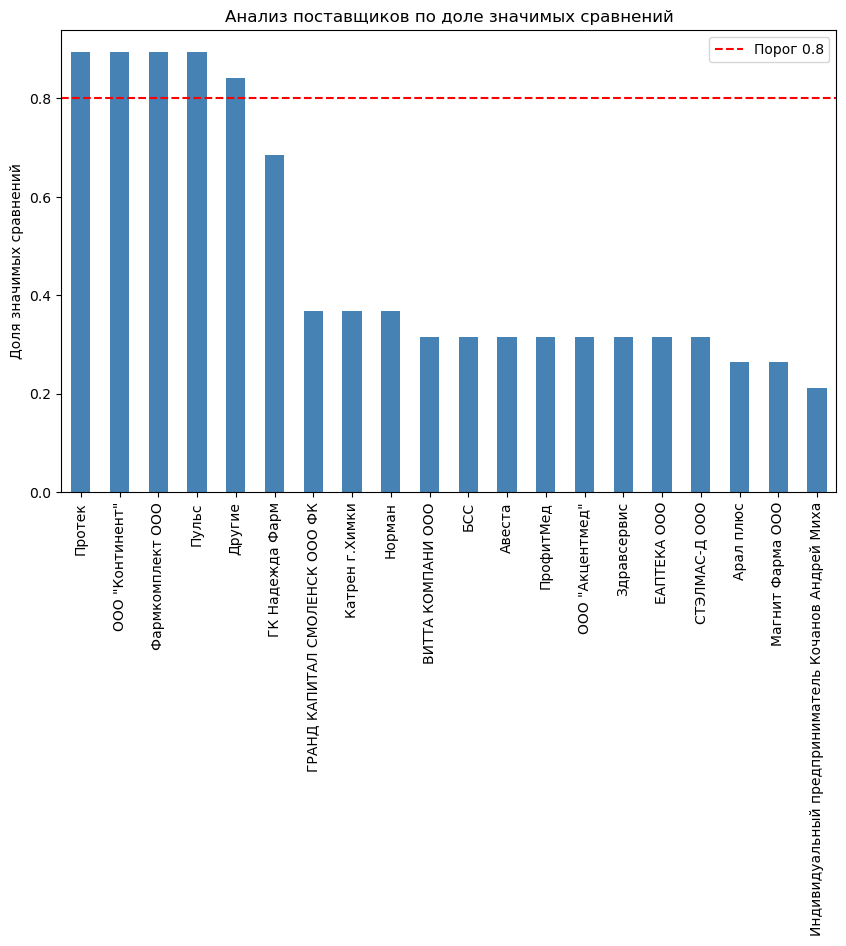

In [11]:
alpha = 0.05

# с: значимые различия (1) / нет (0)
binary_matrix = (dunn < alpha).astype(int)

# Доля значимых сравнений для каждой аптеки
significance_ratio = binary_matrix.sum(axis=1) / (binary_matrix.shape[1] - 1)

# Сортируем для удобства
significance_ratio_sorted = significance_ratio.sort_values(ascending=False)

# Построим график
plt.figure(figsize=(10,6))
significance_ratio_sorted.plot(kind="bar", color="steelblue")
plt.axhline(0.8, color="red", linestyle="--", label="Порог 0.8")
plt.ylabel("Доля значимых сравнений")
plt.title("Анализ поставщиков по доле значимых сравнений")
plt.legend()
plt.show()

- «Пульс», «Фармкомплект ООО», «Протек», «ООО Континент» и группа «Другие» находятся выше порога 0.8, то есть они статистически чаще всего отличаются от остальных поставщиков.
- Это значит, что их профиль продаж и прибыльности нетипичен, и они формируют отдельные кластеры.

#### Матрица поставщиков: Объем продаж vs Средний чек

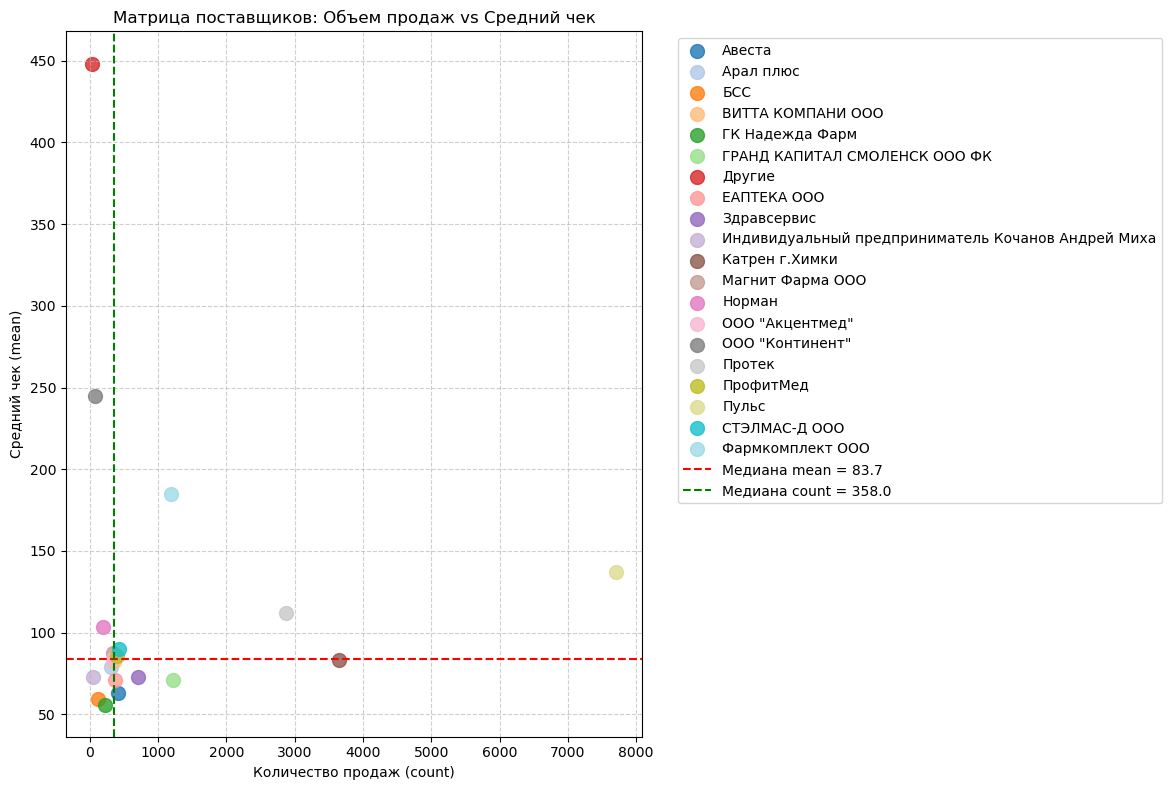

In [12]:
# === Подготовка данных ===
supplier_grouped = grouped.groupby('supplier_grouped')['profit'].agg(
    mean='mean',
    median='median',
    count='count'
).reset_index().round(2)

df_suppliers = supplier_grouped.copy()

# Медианы
median_mean = df_suppliers['mean'].median()
median_count = df_suppliers['count'].median()

# Палитра цветов (по числу уникальных поставщиков)
suppliers = df_suppliers['supplier_grouped'].unique()

# Получаем палитру через новый API
colors = plt.colormaps.get_cmap('tab20').resampled(len(suppliers))

# Словарь "поставщик → цвет"
color_dict = {sup: colors(i) for i, sup in enumerate(suppliers)}

# === Построение scatter plot ===
plt.figure(figsize=(12,8))

for i, row in df_suppliers.iterrows():
    plt.scatter(
        row['count'], row['mean'],
        color=color_dict[row['supplier_grouped']],
        s=100, alpha=0.8, label=row['supplier_grouped']
    )
    # подписи прямо рядом с точками
    #plt.text(row['count']+20, row['mean']+5, row['supplier_grouped'], fontsize=8)

# Линии по медианам
plt.axhline(median_mean, color='red', linestyle='--', label=f'Медиана mean = {median_mean:.1f}')
plt.axvline(median_count, color='green', linestyle='--', label=f'Медиана count = {median_count}')

# Подписи и оформление
plt.xlabel("Количество продаж (count)")
plt.ylabel("Средний чек (mean)")
plt.title("Матрица поставщиков: Объем продаж vs Средний чек")

# Легенда (уникальные поставщики)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

#### Матрица поставщиков с учетом вклада в общую выручку

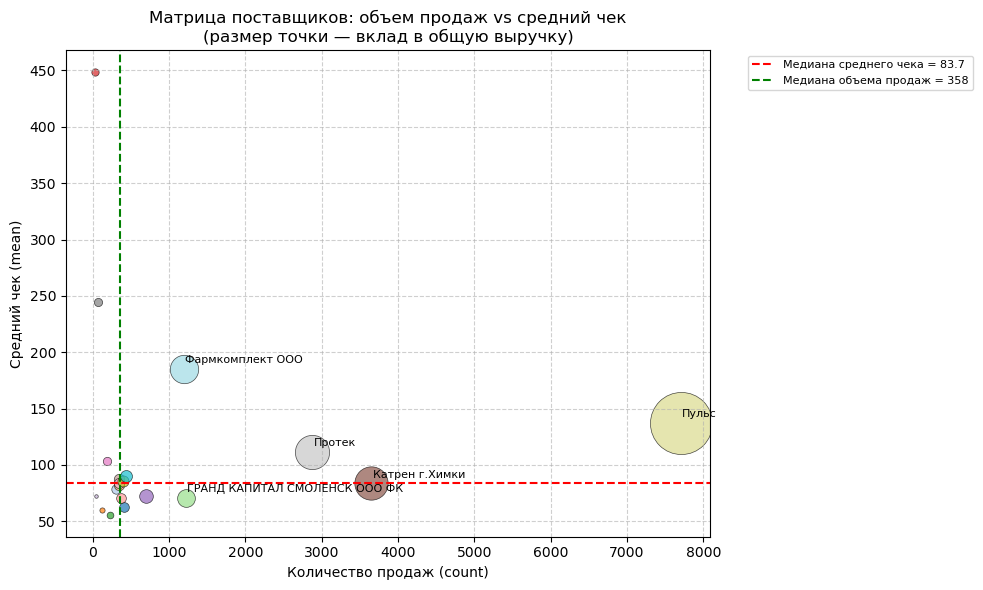

In [13]:
# === Подготовка данных ===
df_suppliers = supplier_grouped.copy()

# Расчёт вклада в общую выручку
df_suppliers["revenue_contrib"] = df_suppliers["count"] * df_suppliers["mean"]

# Для масштабирования размеров точек (чтобы не были слишком большими)
max_contrib = df_suppliers["revenue_contrib"].max()
df_suppliers["size"] = (df_suppliers["revenue_contrib"] / max_contrib) * 2000  # масштаб подбирается под визуал

# Медианы
median_mean = df_suppliers['mean'].median()
median_count = df_suppliers['count'].median()

# Палитра цветов (по числу уникальных поставщиков)
suppliers = df_suppliers['supplier_grouped'].unique()
colors = plt.colormaps.get_cmap('tab20').resampled(len(suppliers))

# Словарь поставщик → цвет
color_dict = {sup: colors(i) for i, sup in enumerate(suppliers)}

# === Построение scatter plot ===
plt.figure(figsize=(10,6))

for i, row in df_suppliers.iterrows():
    plt.scatter(
        row['count'], row['mean'],
        color=color_dict[row['supplier_grouped']],
        s=row['size'],           # размер точки = вклад в выручку
        alpha=0.7,
        edgecolor='black',
        linewidth=0.5
    )
    # Подписи для крупных поставщиков (по вкладу)
    if row["revenue_contrib"] > 0.05 * max_contrib:  # подписи только топ-5% по вкладу
        plt.text(row['count'] + 20, row['mean'] + 5, row['supplier_grouped'], fontsize=8)

# Линии по медианам
plt.axhline(median_mean, color='red', linestyle='--', label=f'Медиана среднего чека = {median_mean:.1f}')
plt.axvline(median_count, color='green', linestyle='--', label=f'Медиана объема продаж = {median_count:.0f}')

# Подписи и оформление
plt.xlabel("Количество продаж (count)")
plt.ylabel("Средний чек (mean)")
plt.title("Матрица поставщиков: объем продаж vs средний чек\n(размер точки — вклад в общую выручку)")

# Легенда (уникальные поставщики)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Если провести медианы по обеим осям, то график делится на 4 квадранта, каждый из которых отражает разную бизнес-стратегию взаимодействия с поставщиком.

**Интерпретация квадрантов (общая логика)**

| Квадрант             | Характеристика                           | Бизнес-смысл                                | Стратегия                                                                 |
|----------------------|------------------------------------------|---------------------------------------------|---------------------------------------------------------------------------|
| I (право-верхний)    | Высокий объём и высокий средний чек      | Поставщики приносят основную прибыль        | Лидеры — приоритетное сотрудничество, условия сохранить               |
| II (лево-верхний)    | Низкий объём, но высокий средний чек     | Товары дорогие, но продаж немного           | Перспективные — можно развивать продажи, расширять ассортимент        |
| III (право-нижний)   | Высокий объём, но низкий средний чек     | Массовый поток, но низкая маржа             | Поддержка — нужны для оборота, но стоит оптимизировать закупочные цены |
| IV (лево-нижний)     | Низкий объём и низкий средний чек        | Почти не дают прибыли                       | Слабые — кандидаты на пересмотр или исключение                        |

**Лидеры (право-верхний)**  
Пульс, Фармкомплект ООО, Протек, Катрен г.Химки  
→ Большой объём продаж и достаточно высокий средний чек.  
Вывод: это ключевые поставщики, обеспечивающие основную выручку.  
Рекомендация: поддерживать устойчивые отношения, возможно — бонусные контракты или улучшение логистики.  

**Перспективные (лево-верхний)**  
ООО "Континент", Другие, ГК Надежда Фарм  
→ Продаж немного, но средний чек выше медианы.  
Вывод: товары потенциально прибыльные, но мало продаются.  
Рекомендация: изучить ассортимент, рассмотреть маркетинговую поддержку, чтобы нарастить объём.  

**Поддержка (право-нижний)**  
Норман, Здравсервис, ГРАНД КАПИТАЛ СМОЛЕНСК ООО ФК, ЕАПТЕКА ООО, Авеста  
→ Большой объём, но невысокий средний чек.  
Вывод: поставщики поддерживают поток, но не дают высокую прибыльность.  
Рекомендация: провести переговоры по ценам, улучшить наценку или частично заменить ассортимент.  

**Слабые (лево-нижний)**  
БСС, Магнит Фарма ООО, ПрофитМед, ООО "Акцентмед", Арал плюс, ИП Кочанов  
→ Низкий объём и низкий средний чек.  
Вывод: низкий вклад в бизнес, незначительное влияние на прибыль.  
Рекомендация: оценить целесообразность сотрудничества — либо сократить, либо вывести из ассортимента.   

**Результаты**

Тест: Kruskal–Wallis H-test. 
- H = 1297.24, p = 1.38 × 10⁻²⁶³
Проверка показала статистически значимые различия между поставщиками, нулевая гипотеза отвергается.

Размер эффекта:
- Eta squared (η²) = 0.061
Эффект умеренной силы, что указывает на заметные различия в структуре прибыльности между группами поставщиков.

Пост-хок анализ (Dunn test, Bonferroni correction):
- Обнаружено множество статистически значимых пар различий.
- Наибольшие различия зафиксированы между поставщиками с разными стратегиями ценообразования и ассортиментом.

Анализ доли значимых сравнений (по аналогии с post-hoc heatmap):
- Поставщики «Пульс», «Фармкомплект ООО», «Протек», «ООО Континент», а также агрегированная группа «Другие»
показали долю значимых различий выше 0.8.
- Это означает, что их структура продаж и прибыльности статистически чаще отличается от остальных поставщиков.

Кластеризация по матрицам (продажи × прибыль):
- Визуализация по среднему чеку и объёму продаж выявила отдельный кластер крупных и высокоприбыльных поставщиков,
а также кластер низкомаржинальных поставщиков, характерных для розничных аптечных сетей.

При учёте вклада в общую выручку видно, что топ-3 поставщика обеспечивают непропорционально большую долю прибыли,
формируя зависимость бизнеса от ограниченного числа партнёров. 

Различия между поставщиками статистически значимы, и они не просто случайные колебания. Однако сила эффекта умеренная: поставщик объясняет часть вариации, но далеко не всё. Это значит, что cуществуют поставщики, с которыми бизнес получает выше/ниже прибыль. Но ещё большее влияние оказывают другие факторы (например, категории товаров, скидки, аптека, объёмы закупки и т.д.).  

**Значение для бизнеса**  

1. Поставщики формируют неоднородный профиль прибыльности.  
Различия статистически значимы и имеют умеренный размер эффекта, что свидетельствует о существенных стратегических различиях в марже, условиях закупок и позиционировании.  

2. Существуют выделенные группы поставщиков:  
- Высокоприбыльные: «Пульс», «Фармкомплект ООО», «Протек», «ООО Континент».  
Эти контрагенты обеспечивают стабильно высокий уровень маржи и оборота.  
- Низкоприбыльные или нестабильные: ряд мелких и региональных поставщиков (в т.ч. в группе «Другие»).  

3. Концентрация прибыли:  
Основной вклад в маржинальный результат формируют 3–4 ключевых поставщика.  
Это создаёт зависимость сети от ограниченного числа партнёров и требует стратегического контроля условий работы с ними.  

**Рекомендации**

1. Оптимизация портфеля поставщиков
- Провести пересмотр условий закупок и скидок для поставщиков, показавших статистически низкий уровень прибыльности.
- Рассмотреть возможность перераспределения закупок в пользу поставщиков из высокоприбыльного кластера.

2. Пересмотр ассортиментной политики
- Проанализировать номенклатуру товаров у поставщиков с низкой рентабельностью.
- Исключить или ограничить товары, не обеспечивающие целевую маржинальность (например, по принципу Парето 80/20).

3. Контроль зависимости от ключевых партнёров
- Разработать стратегию диверсификации поставок, чтобы снизить риск концентрации прибыли на ограниченном пуле контрагентов.
- Использовать показатели прибыльности по поставщику как один из KPI в системе закупочного планирования.

4. Аналитический мониторинг
- Внедрить регулярный отчёт «прибыль по поставщику» с обновлением по периодам.
- Включить в него динамику средней маржи, объёма продаж и долю в общей выручке.